In [4]:
!pip install tensorflow_datasets

^C


In [5]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt 
import numpy as np

In [6]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info = True) #what does the 3.*.* mean?

In [7]:
dataset

{'train': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 'test': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

In [8]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir='C:\\Users\\muham\\tensorflow_datasets\\oxford_iiit_pet\\3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=

In [9]:
def resize_image(input_image, input_mask):
    input_image = tf.image.resize(input_image, (128,128), method = 'nearest')
    input_mask = tf.image.resize(input_mask, (128,128), method = 'nearest')
    return (input_image, input_mask)

In [10]:
def augment(input_image, input_mask):
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    return input_image, input_mask

In [11]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32)/ 255.0
    input_mask -= 1
    return input_image, input_mask

In [12]:
def load_image_train(datapoint):
    input_image = datapoint['image']
    input_mask = datapoint['segmentation_mask']
    input_image, input_mask = resize_image(input_image, input_mask)
    input_image, input_mask = augment(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

def load_image_test(datapoint):
    input_image= datapoint['image']
    input_mask = datapoint['segmentation_mask']
    input_image, input_mask = resize_image(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

In [13]:
train_dataset = dataset['train'].map(load_image_train, num_parallel_calls = tf.data.AUTOTUNE)
test_dataset = dataset['test'].map(load_image_test, num_parallel_calls = tf.data.AUTOTUNE)

In [14]:
train_dataset

<_ParallelMapDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None))>

In [15]:
print(len(train_dataset), len(test_dataset))

3680 3669


In [16]:
BATCH_SIZE = 64
BUFFER = 1000
train_batches = train_dataset.cache().shuffle(BUFFER).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(699).batch(BATCH_SIZE)

In [17]:
BATCH_SIZE = 64
BUFFER_NUM = 1000
train_batches = train_dataset.cache().shuffle(BUFFER_NUM).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

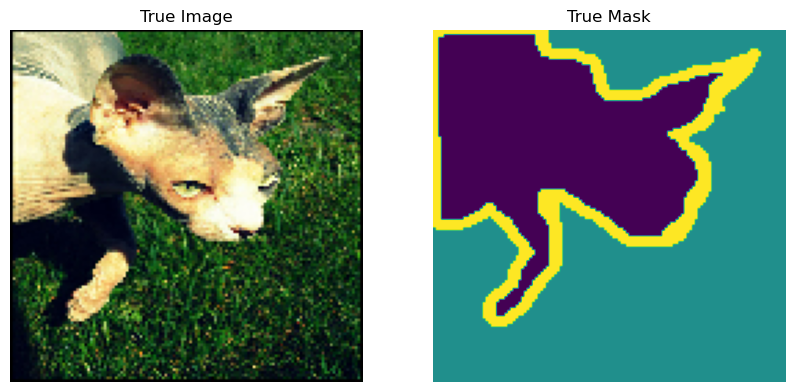

In [18]:
def display(display_list):
    plt.figure(figsize= (10,10))
    labels = ['True Image', 'True Mask', 'Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1,len(display_list), i+1)
        plt.title(labels[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

      

In [19]:
def double_conv_block(x, num_filters):
    x = layers.Conv2D(num_filters, 3, padding = 'same', activation = 'relu', kernel_initializer= 'he_normal')(x)
    x = layers.Conv2D(num_filters, 3, padding = 'same', activation = 'relu', kernel_initializer= 'he_normal')(x)
    return x

In [24]:
def downsample_block(x, num_filters):
    c = double_conv_block(x, num_filters)
    p = layers.MaxPooling2D(2)(c)
    p = layers.Dropout(0.3)(p)
    return c, p

In [28]:
def upsample_block(x, conv_features, num_filters):
    x = layers.Conv2DTranspose(num_filters, 3, 2, padding = 'same')(x)
    x = layers.concatenate([x, conv_features])
    x = layers.Dropout(0.3)(x)
    x = double_conv_block(x, num_filters)
    return x

In [29]:
# 64 - 1024
def build_unet():
    input = layers.Input(shape=(128,128,3))
    
    c1, p1 = downsample_block(input, 64)
    c2, p2 = downsample_block(p1, 128)
    c3, p3 = downsample_block(p2, 256)
    c4, p4 = downsample_block(p3, 512)
    
    bottleneck = double_conv_block(p4, 1024)
    
    u4 = upsample_block(bottleneck, c4, 512)
    u3 = upsample_block(u4, c3, 256)
    u2 = upsample_block(u3, c2, 128)
    u1 = upsample_block(u2, c1, 64)
    
    output = layers.Conv2D(3, 1, activation = 'softmax', padding = 'same')(u1)
    
    unet_model = tf.keras.Model(input, output, name = 'U-Net')
    
    return unet_model

In [30]:
unet_model = build_unet()

In [31]:
unet_model.compile(optimizer = 'adam',
                   loss = tf.keras.losses.SparseCategoricalCrossentropy,
                   metrics = ['accuracy'])

In [100]:
NUM_EPOCHS = 20

TRAIN_LENGTH = info.splits['train'].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH//BATCH_SIZE

VAL_SUBSPLITS = 5
VALIDATION_LENGTH = info.splits['test'].num_examples
VALIDATION_STEP = VALIDATION_LENGTH//BATCH_SIZE//VAL_SUBSPLITS

archive = unet_model.fit(train_batches, 
                    validation_data = validation_batches,
                    epochs = NUM_EPOCHS,
                    steps_per_epoch = STEPS_PER_EPOCH,
                    validation_steps = VALIDATION_STEP
                    )

Epoch 1/20
 9/57 ━━━━━━━━━━━━━━━━━━━━ 9:38 12s/step - accuracy: 0.5150 - loss: 1.1602

KeyboardInterrupt: 

In [32]:
test_batches

<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.uint8, name=None))>

In [34]:
image, mask = test_batches.take(2)

In [35]:
image

(<tf.Tensor: shape=(64, 128, 128, 3), dtype=float32, numpy=
 array([[[[1.        , 1.        , 1.        ],
          [0.99215686, 0.99215686, 0.99215686],
          [0.9882353 , 0.9882353 , 0.9882353 ],
          ...,
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ]],
 
         [[0.99215686, 0.99215686, 0.99215686],
          [1.        , 1.        , 1.        ],
          [0.94509804, 0.94509804, 0.94509804],
          ...,
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ]],
 
         [[0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843],
          ...,
          [1.        , 1.        , 1.        ],
          [0.99607843, 0.99607843, 0.99607843],
          [1.        , 1.        , 1.        ]],
 
         ...,
 
      

In [101]:
def create_mask(pred_mask):
 pred_mask = tf.argmax(pred_mask, axis=-1)
 pred_mask = pred_mask[..., tf.newaxis] 
 return pred_mask[0]

def show_predictions(dataset=None, num=1):
 if dataset:
   for image, mask in dataset.take(num):
     pred_mask = unet_model.predict(image)
     display([image[0], mask[0], create_mask(pred_mask)])
 else:
   display([sample_image, sample_mask,
            create_mask(model.predict(sample_image[tf.newaxis, ...]))])

count = 0
for i in test_batches:
   count +=1
print("number of batches:", count)

number of batches: 11


In [39]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred.mask, axis =-1)
    pred_mask = pred_mask[:,tf.newaxis]
    return pred_mask[0]
def show_predictions(dataset = None, num = 1):
    if dataset:
        for image, mask in dataset.take(1):            # to take separate tensors from prefetch object you need to extract with take
            pred_mask = unet_model.predict(image)
            display([image[0], mask[0], pred_mask])
    else:
        display([sample_image, sample_mask,
                 create_mask(unet_model.predict(sample_image[tf.newaxis, ...]))])
        

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


ValueError: Expected image array to have rank 3 (single image). Got array with shape: (64, 128, 128, 3)

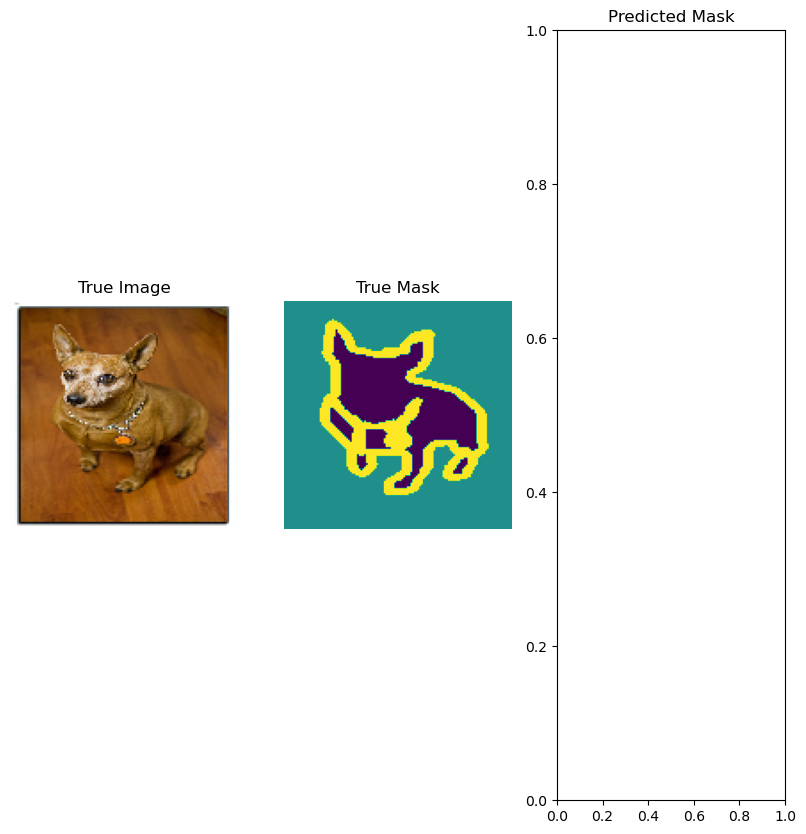

In [40]:
show_predictions(test_batches)